# Homework 2: denoising dogs

In this homework you'll write a CNN model to remove distortions/noise from nice dog images.

There is a dataset class which always adds some nasty random shapes to the images; the result is our network input. The target is the original image.

Your task is:

1. Complete the `DenoiseNet` inside `model_denoise.py`
2. Complete the `train_valid_loop` inside `train_dogs.py`
3. Train the network (GPU recommended) until you get a validation loss below X
4. Push to git

### Preamble

In [116]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as func
from tqdm.notebook import tqdm
from PIL import Image
import glob

In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cd /content/drive/MyDrive/ML_2023/homework2_2023/

/content/drive/MyDrive/ML_2023/homework2_2023


### Download the dataset by uncommenting the following:

In [ ]:
#!wget https://www.dropbox.com/s/nseb35op6ak7zvm/dog-breeds.zip

In [ ]:
#!unzip dog-breeds.zip

### Extract the full list of paths to train and validation images

- We will randomly select a fraction of 80% of the images for the training dataset and the remaining 20% for validation.
- We aren't using the breed label for now, but it would be interesting to do a classification task on this dataset!
- In fact, we are using only the rottweilers to make things a little easier

In [164]:
dogs_train = {}
dogs_valid = {}
train_valid_split = 0.85

for breed in glob.glob('dog-breeds/*'):
    breed = breed.split('/')[1]
    if breed != 'rottweiler':
        continue
    dogs_in_breed = glob.glob('dog-breeds/'+breed+'/*')
    for dog in dogs_in_breed:
        if np.random.rand() < train_valid_split: # train-validation split
            dogs_train[dog] = breed
        else:
            dogs_valid[dog] = breed

Use the PIL library to convert a JPG path to an Image object

In [165]:
images = [Image.open(path) for path in dogs_train.keys()]

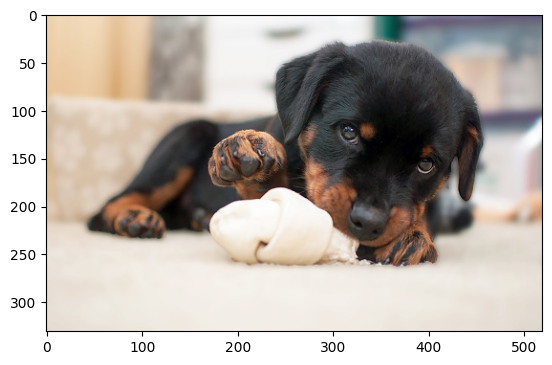

In [166]:
plt.imshow(images[25])

### Import our custom dataset that adds random noise (shapes) each time you grab an image

In [167]:
from custom_dataset import CustomDataset

In [168]:
train_ds = CustomDataset(list(dogs_train.keys()),list(dogs_train.values()))
valid_ds = CustomDataset(list(dogs_valid.keys()),list(dogs_valid.values()))

### Plot an example

/Users/ets/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


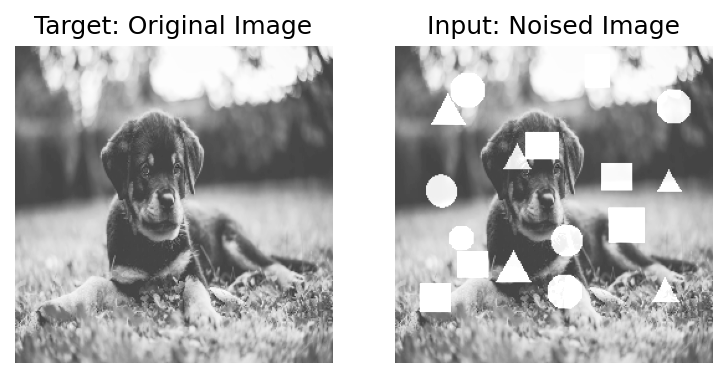

In [169]:
x, y = train_ds[10]

fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].imshow(y.squeeze(0,1),cmap='Greys_r',vmin=0,vmax=1)
ax[0].set_title('Target: Original Image')
ax[1].imshow(x.squeeze(0,1),cmap='Greys_r',vmin=0,vmax=1)
ax[1].set_title('Input: Noised Image')

for i in range(2):
    ax[i].set_axis_off()

plt.show()

### Import the CNN model

In [185]:
from model_denoise import DenoiseNet

In [186]:
net = DenoiseNet()

In [187]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=True)

### The training loop

In [188]:
from train_dogs import train_valid_loop

In [189]:
train_loss, valid_loss = train_valid_loop(net, train_dl, valid_dl, Nepochs=50, learning_rate=1e-3)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  0  Train loss:  0.26721111238002776  Valid loss:  0.08268913626670837
Epoch:  1  Train loss:  0.13827179223299027  Valid loss:  0.1235310360789299
Epoch:  2  Train loss:  0.0878545582294464  Valid loss:  0.11918529123067856
Epoch:  3  Train loss:  0.0630271665751934  Valid loss:  0.10609292984008789
Epoch:  4  Train loss:  0.04211676567792892  Valid loss:  0.07836558669805527
Epoch:  5  Train loss:  0.034827901422977446  Valid loss:  0.06286021322011948
Epoch:  6  Train loss:  0.03182837069034576  Valid loss:  0.04786715283989906
Epoch:  7  Train loss:  0.02293388284742832  Valid loss:  0.037319306284189224
Epoch:  8  Train loss:  0.019851157814264296  Valid loss:  0.033687036484479904
Epoch:  9  Train loss:  0.01948825251311064  Valid loss:  0.028323868289589882
Epoch:  10  Train loss:  0.01998306214809418  Valid loss:  0.020569613203406334
Epoch:  11  Train loss:  0.01982918046414852  Valid loss:  0.019373763352632523
Epoch:  12  Train loss:  0.017153034172952174  Valid loss:

### Load the best model from training

In [190]:
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

### Plot the training and validation losses

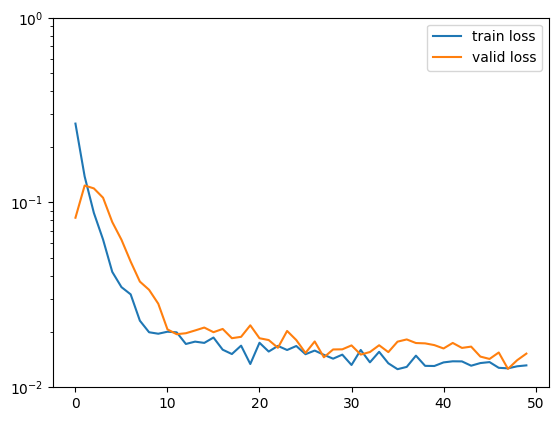

In [191]:
fig, axes = plt.subplots()
axes.plot(range(len(train_loss)),train_loss,label='train loss')
axes.plot(range(len(valid_loss)),valid_loss,label='valid loss')
axes.set_yscale('log')
axes.set_ylim([1e-2,1e0])
axes.legend()
plt.show()

### A loss below 0.015 over the full rotweiler dataset should have been reached during the training to pass the assignment

In [211]:
from evaluate_dogs import evaluate_on_dataset
total_loss = evaluate_on_dataset()
print(total_loss)

0.012742054462432862


### Voila!

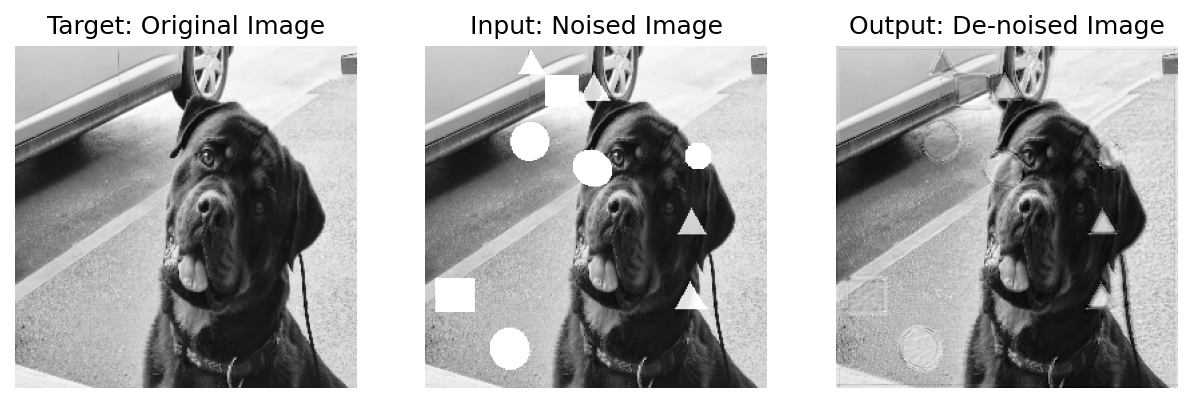

In [202]:
x, y = valid_ds[2]

xprime = net(x.unsqueeze(0)).detach()

fig,ax = plt.subplots(1,3,figsize=(10,3),dpi=150)

ax[0].imshow(y.squeeze(0 ),cmap='Greys_r',vmin=0,vmax=1)
ax[0].set_title('Target: Original Image')
ax[1].imshow(x.squeeze(0),cmap='Greys_r',vmin=0,vmax=1)
ax[1].set_title('Input: Noised Image')
ax[2].imshow(xprime.squeeze(0,1),cmap='Greys_r',vmin=0,vmax=1)
ax[2].set_title('Output: De-noised Image')

for i in range(3):
    ax[i].set_axis_off()

plt.show()